In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torchvision import models, datasets
from torch.autograd import Variable

#from data_utils.data_setup import get_imagenet_test, get_top_prediction, get_imagenet_classes
#from techniques.gen_patch import gen_adversarial_patch
from metrics.utils import *
from techniques.utils import get_displ_img
#from techniques.generate_grounding import gen_grounding

datadir = '../data/test/'
#datadir = '../data/ILSVRC2012_img_val/'
save_path='../results/explanation_examples/'

In [2]:
from techniques.generate_grounding import gen_grounding

In [3]:
displ_img = cv2.imread('/work/lisabdunlap/explain-eval/data/samples/cat_dog.png')

# Mask/Heatmap Methods

### Grad-Cam

result path: ./cat_dog/
	#0: boxer (0.42589)
saving explanation mask....

saved to ./cat_dog/gcam-resnet18


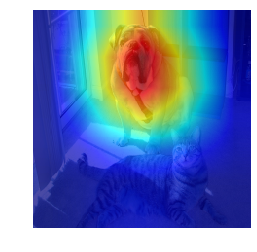

In [4]:
#generate image for the predicted class
gcam_expl = gen_grounding(displ_img,
                          'gcam',
                          'cat_dog',
                          'resnet18',
                          target_index=1,
                          layer='layer4',
                          show=True,
                          save=True,
                          save_path='./',
                          device=2)

result path: ./cat_dog/cat/
saving explanation mask....

saved to ./cat_dog/cat/gcam-resnet18


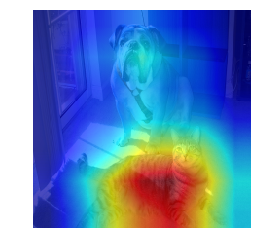

In [5]:
#generate image wrt a specific class index
gcam_expl_cat = gen_grounding(displ_img,
                              'gcam',
                              'cat_dog/cat',
                              'resnet18',
                              target_index=282,
                              show=True,
                              save=True,
                              save_path='./',
                              device=2,
                              index=True)

### LIME

In [1]:
lime_expl= gen_grounding(displ_img,
                         'lime',
                         'cat_dog',
                         'resnet18',
                         target_index=1,
                         show=True,
                         save=True,
                         save_path='./')

NameError: name 'gen_grounding' is not defined

In [ ]:
lime_expl_cat= gen_grounding(displ_img,
                             'lime',
                             'cat_dog/cat',
                             'resnet18',
                             target_index=3,
                             show=True,
                             save=True,
                             save_path='./')

### RISE

In [ ]:
rise_expl = gen_grounding(displ_img,
                          'rise',
                          'cat_dog',
                          'resnet18',
                          target_index=1,
                          show=True,
                          save=True,
                          save_path='./',
                          device=3)

In [ ]:
rise_expl_cat = gen_grounding(displ_img,
                              'rise',
                              'cat_dog/cat',
                              'resnet18',
                              target_index=3,
                              show=True,
                              save=True,
                              save_path='./',
                              device=3)

# Saliency Methods

### Integrated Gradients

result path: ./cat_dog/
finished Integrated Gradients explanation
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/ig-resnet18


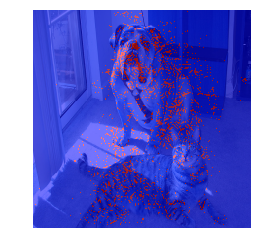

In [16]:
ig_expl = gen_grounding(displ_img,
                       'ig',
                       'cat_dog',
                       'resnet18',
                       show=True,
                       save=True,
                       target_index=1,
                       save_path='./',
                       device=0,
                       index=False)

finished Integrated Gradients explanation
after  (224, 224)


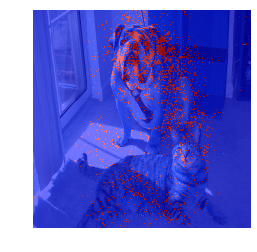

In [17]:
ig_expl_cat = gen_grounding(displ_img,
                       'ig',
                       'cat_dog',
                       'resnet18',
                       show=True,
                       save=True,
                       target_index=242,
                       save_path='./',
                       device=0,
                       index=True)

In [ ]:
ig_expl_cat = gen_grounding(displ_img,
                       'ig',
                       'cat_dog/cat',
                       'resnet18',
                       show=True,
                       save=True,
                       target_index=282,
                       save_path='./',
                       device=0,
                       index=True)

### Vanilla Backpropigation

result path: ./cat_dog/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/bp-resnet18


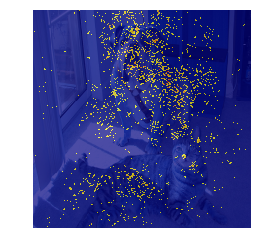

In [4]:
#generate image for the predicted class
bp_expl = gen_grounding(displ_img,
                        'bp',
                        'cat_dog',
                        'resnet18', 
                        target_index=1,
                        layer='layer4.2',
                        show=True, 
                        save=True,
                        save_path='./',
                        device=2)

result path: ./cat_dog/cat/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/cat/bp-resnet18


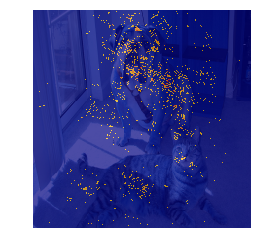

In [6]:
#generate image wrt a specific class index
bp_expl_dog = gen_grounding(displ_img, 
                            'bp', 
                            'cat_dog/top1', 
                            'resnet18', 
                            target_index=242, 
                            show=True, 
                            save=True, 
                            save_path='./',
                            device=2, 
                            index=True)

result path: ./cat_dog/cat/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/cat/bp-resnet18


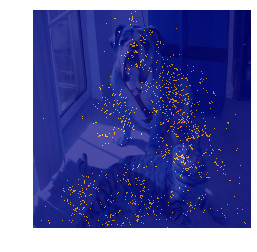

In [9]:
#generate image wrt a specific class index
bp_expl_cat = gen_grounding(displ_img, 
                            'bp', 
                            'cat_dog/cat', 
                            'resnet18', 
                            target_index=282, 
                            show=True, 
                            save=True, 
                            save_path='./',
                            device=2, 
                            index=True)

	#0: boxer (0.42589)
	#0: bull_mastiff (0.26502)
	#0: tiger_cat (0.17546)
after  (224, 224)


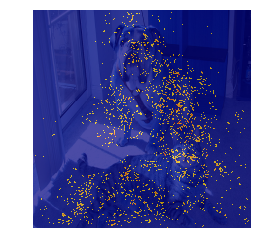

In [4]:
#generate image for the predicted class
bp_expl_test = gen_grounding(displ_img,
                        'bp',
                        'cat_dog/top3',
                        'resnet18', 
                        target_index=3,
                        layer='layer4.2',
                        show=True, 
                        save=True,
                        save_path='./',
                        device=2)

### Guided Backpropigation

result path: ./cat_dog/cat/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/cat/gbp-resnet18


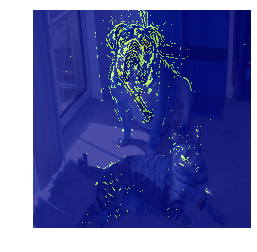

In [7]:
#generate image for the predicted class
'''gbp_expl = gen_grounding(displ_img, 
                         'gbp', 
                         'cat_dog', 
                         'resnet18',
                         target_index=1,
                         layer='layer4.2',
                         show=True,
                         save=True,
                         save_path='./',
                         device=2)'''
#generate image wrt a specific class index
gbp_expl_cat = gen_grounding(displ_img,
                            'gbp',
                            'cat_dog/cat',
                            'resnet18',
                            target_index=242, 
                            show=True,
                            save=False,
                            save_path='./',
                            device=2,
                            index=True)

result path: ./cat_dog/top1/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/top1/gbp-resnet18


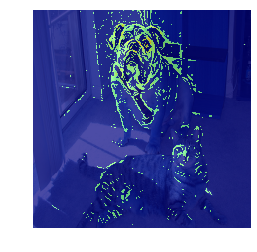

In [13]:
gbp_expl = gen_grounding(displ_img, 
                         'gbp', 
                         'cat_dog/top1', 
                         'resnet18',
                         target_index=1,
                         layer='layer4.2',
                         show=True,
                         save=True,
                         save_path='./',
                         device=2)

result path: ./cat_dog/top3/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/top3/gbp-resnet18


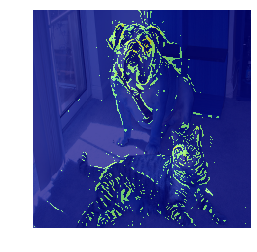

In [14]:
gbp_expl = gen_grounding(displ_img, 
                         'gbp', 
                         'cat_dog/top3', 
                         'resnet18',
                         target_index=3,
                         layer='layer4.2',
                         show=True,
                         save=True,
                         save_path='./',
                         device=2)

result path: ./cat_dog/cat/
after  (224, 224)
saving explanation mask....

saved to ./cat_dog/cat/gbp-resnet18


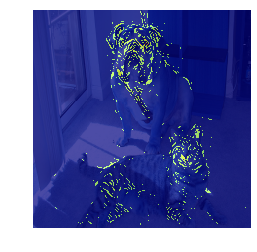

In [15]:
#generate image wrt a specific class index
gbp_expl_cat = gen_grounding(displ_img,
                            'gbp',
                            'cat_dog/cat',
                            'resnet18',
                            target_index=282, 
                            show=True,
                            save=True,
                            save_path='./',
                            device=2,
                            index=True)

# Plot Explanations

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
cams = [gcam_expl, lime_expl, rise_expl, bp_expl, gbp_expl, ig_expl]
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),
                 axes_pad=0.35,  # pad between axes in inch.
                 )

for ax, im in zip(grid, cams):
    ax.axis('off')
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

# Get Stats

In [56]:
iou_pix, cos_dist, js_dist, tvd, cc = get_stats(np.float32(ig_mask), lime_mask, threshold=10)

pixel count IoU: 0.004022191400832178
cos similarity: 0.8182256808217385
Jenson Shannon dist: 0.7215742216816708
total variation distance: 0.9933854557551773
Pearsons Correlation Coefficient: -0.05971653644705394
------------------------------


## Calculate IoU

In [ ]:
from techniques.utils import calc_iou, weight_mask

In [ ]:
iou, intersection, union = calc_iou(gcam_mask, lime_mask, threshold=50, num_pixels=True)
print("IoU pixel value sum: {0}".format(iou))

#### Check IoU

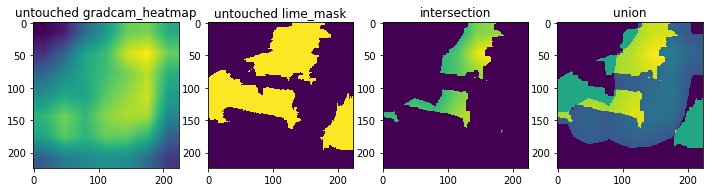

In [87]:
_, axs = plt.subplots(1, 4, figsize=(12, 12))
axs = axs.flatten()
imgs = [gcam_mask, lime_mask, intersection, union]
labels = ['untouched gradcam_heatmap', 'untouched lime_mask', 'intersection', 'union']
for img, ax, label in zip(imgs, axs, labels):
    ax.set_title(label)
    ax.imshow(img)
plt.show()